In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('reddit.csv')

In [3]:
df.head()

,Unnamed: 0,ID,comments,posts,roles,predicates,labels
0,0,hgz26,"[""If the cops won't do anything about it... ma...",My father abuses me and I cant do anything abo...,"['am-adv', 'am-adv', 'am-adv', 'am-adv', 'am-d...","[('do', '02'), ('know', '01'), ('make', '01'),...",abuse
1,1,2vpmnh,['I re-read your post and realized it\'s past ...,[Help]Finger Prick I know how dumb it sounds o...,"['am-adv', 'am-adv', 'am-dis', 'am-mnr', 'am-m...","[('!think', '01'), ('be', '01'), ('have', '03'...",non_abuse
2,2,2urnes,"[""Dealing with seniors? What exactly does that...",Going to college stress. I've had two panic at...,"['am-mnr', 'emotion or sensation', 'end point,...","[('do', '02'), ('feel', '01'), ('go', '01'), (...",non_abuse
3,3,2l78vr,"[""Yeah I am the same I get terrible anxiety, t...",Just started my Sertraline medication today. I...,"['am-adv', 'am-adv', 'am-dis', 'am-mnr', 'am-m...","[('change', '01'), ('start', '01'), ('change',...",non_abuse
4,4,136f5k,"[""So what I am getting is you're suffering fro...","hear me, i cry again and again, and maybe i am...","['am-adv', 'am-adv', 'am-adv', 'am-adv', 'am-a...","[('!be', '01'), ('be', '01'), ('do', '02'), ('...",abuse


In [4]:
df.drop(columns='Unnamed: 0', inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104 entries, 0 to 1103
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          1104 non-null   object
 1   comments    1104 non-null   object
 2   posts       1104 non-null   object
 3   roles       1104 non-null   object
 4   predicates  1104 non-null   object
 5   labels      1104 non-null   object
dtypes: object(6)
memory usage: 51.9+ KB


In [6]:
df.ID.duplicated().any()

False

# Adding Features & Preprocessing Text

## Readability

In [7]:
import textstat

In [8]:
df['flesch_score_posts']=df.posts.apply(textstat.flesch_reading_ease)

In [9]:
df.comments[0][:315]

'["If the cops won\'t do anything about it... maybe the ASPCA will. \\n\\nDon\'t bother with cops. Go straight to social services. \\n\\nEven under the divorce agreement, you and you family can get a restraining order that will make him move out. Collect copies of the police reports you have made and take them to court. '

In [10]:
#read_csv reads list of comments as string of lists - convert to list
df.comments=df.comments.apply(eval)

In [11]:
df.comments=df.comments.apply(lambda x: [comment for thread in x for comment in thread.split('\n') if comment!=''])

In [12]:
df.comments[0][:3]

["If the cops won't do anything about it... maybe the ASPCA will. ",
 "Don't bother with cops. Go straight to social services. ",
 'Even under the divorce agreement, you and you family can get a restraining order that will make him move out. Collect copies of the police reports you have made and take them to court. ']

In [13]:
#convert list of strings into one string
df['processed_comments']=[' '.join(map(str, com)) for com in df['comments']]
df['flesch_score_comments']=df.processed_comments.apply(textstat.flesch_reading_ease)

## Emoji

In [14]:
import demoji

In [15]:
emojis=df.posts.apply(demoji.findall)
emojis[emojis!={}]

Series([], Name: posts, dtype: object)

In [16]:
emojis=df.processed_comments.apply(demoji.findall)
emojis[emojis!={}]

Series([], Name: processed_comments, dtype: object)

There are no emojis in these posts. It's not uncommon for Redditors to avoid using emojis, based upon this Reddit thread: https://www.reddit.com/r/TooAfraidToAsk/comments/aad2ao/why_dont_people_use_emojis_on_reddit/.

## Capitalization

In [17]:
def num_caps(text):
    text = ''.join(list(filter(str.isalpha,text)))
    return sum([ch.isupper() for ch in text])/len(text)

df['post_caps']=df.posts.apply(num_caps)
df['comments_caps']=df.processed_comments.apply(num_caps)

## Tokenization

In [18]:
from urllib.parse import urlparse
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.stem import WordNetLemmatizer

#create a function to preprocess text
def preprocessing(text, option='none'):
    
    #remove square brackets first before standardizing url so we avoid the error 'Invalid IPv6 URL'
    s=re.sub(r'[[\]]', ' ', text)
    
    #standardize urls
    urlscan=re.findall(r'(https?://[^\s]+)', s)
    if urlscan:
        for i in range(len(urlscan)):
            url=urlparse(urlscan[i]).netloc
            s=s.replace(urlscan[i], 'url'+url.split('.')[1])
    
    #convert to lowercase
    s=s.lower()
    
    #remove numbers
    s=re.sub(r'\d+', ' ', s)

    #remove punctuation
    s=s.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))

    if option=='char':
        return len(s) #preserve character count
    
    #remove stop words
    tokens=word_tokenize(s)
    
    if option=='word':
        return len(tokens) #preserve word count
    
    if option=='none':
        sw=stopwords.words('english')+['ive', 'since', 'cant', 'he', 'thing', 'ago', 'also', 'dont', 'ah', \
                                   'hes', 'shes', 'u', 'going', 'like', 'one', 'two', 'got', 'get', 'gonna', \
                                      'know', 'would', 'go', 'maybe', 'really', 'could', 'should']
        result=[word for word in tokens if word not in sw]
    
        #lemmatization
        lem=WordNetLemmatizer()
        s=' '.join([lem.lemmatize(word) for word in result])
        
        return s

In [19]:
df['processed_posts']=df.posts.apply(preprocessing)

In [20]:
#preserve the character and word counts of posts
df['post_char_count']=df.posts.apply(preprocessing, option='char')
df['post_word_count']=df.posts.apply(preprocessing, option='word')

In [21]:
df.processed_posts[0]

'father abuse anything tried dad physically emotionality abusing year old threatens kicked locked house chased tripped started kicking called girl name month end beat pet yell beat u kid time nothing around bad guy year denying never said anything anybody month started seeing shrink depression self esteem problem came conclusion due helped start report thing month mother finally went though divorce talking pretty much stopped cop anything unless recent another month live divorce agreement sabotaging thing make life harder eating food mom barley afford sits front tv day watch stay phone day make phone call every day battle called cop child abuse hotline anything besides idea'

In [22]:
#check post with multiple urls
df.processed_posts[363]

'difference forum estranged parent estranged child via metafilter urlmetafilter gt rabbit hole urlissendai repository observation estranged parent support forum contains comparison forum culture urlissendai discussion site estranged parent child theme discussion urlissendai found estranged parent site possible reason urlissendai estranged parent forum develop toxic dynamic insightful educational topic might triggering'

In [23]:
df['comments_char_count']=df.processed_comments.apply(preprocessing, option='char')
df['comments_word_count']=df.processed_comments.apply(preprocessing, option='word')

In [24]:
df['processed_comments']=df.processed_comments.apply(preprocessing)

In [25]:
df.processed_comments[9]

'located dv agency work started offering service male victim located northern california hour hotline call talk judged weirdness urlcatalystdvservices website interested research agency closer offer service male victim sorry stay strong deleted similar experience friend mine woman though realized early abuse able help way needed various reason seems ridiculous manipulated situation favor wife get angry abusive manipulate anger abuse way definitely caught dangerous sometimes especially situation stop thinking victim start thinking survivor encouraging abuse shape form saying expose behavior way make people something simple placing camera home record behavior daughter witnessed assault police arrived call separated wife side story officer took daughter different room asked saw happened daughter told everything step step color snow brush honestly think turned said said actual arrest kid lie saved huge headache thankfully'

In [26]:
#check for empty tokens
df[df.processed_posts=='']

,ID,comments,posts,roles,predicates,labels,flesch_score_posts,processed_comments,flesch_score_comments,post_caps,comments_caps,processed_posts,post_char_count,post_word_count,comments_char_count,comments_word_count


In [27]:
df[df.processed_comments=='']

,ID,comments,posts,roles,predicates,labels,flesch_score_posts,processed_comments,flesch_score_comments,post_caps,comments_caps,processed_posts,post_char_count,post_word_count,comments_char_count,comments_word_count


In [28]:
df['p_tokens']=[['p_'+word for word in word_tokenize(post)] for post in df.processed_posts]
df.p_tokens=df.p_tokens.apply(' '.join)
df.p_tokens.head(3)

0    p_father p_abuse p_anything p_tried p_dad p_ph...
1    p_help p_finger p_prick p_dumb p_sound p_subre...
2    p_college p_stress p_panic p_attack p_week p_i...
Name: p_tokens, dtype: object

In [29]:
df['c_tokens']=[['c_'+word for word in word_tokenize(comments)] for comments in df.processed_comments]
df.c_tokens=df.c_tokens.apply(' '.join)
df.c_tokens.head(3)

0    c_cop c_anything c_aspca c_bother c_cop c_stra...
1    c_read c_post c_realized c_past c_time c_alrea...
2    c_dealing c_senior c_exactly c_mean c_college ...
Name: c_tokens, dtype: object

In [30]:
df['tokens']=df.p_tokens+df.c_tokens

In [31]:
df['labels_num']=df['labels'].map({'non_abuse':0, 'abuse':1})

## Sentiments

In [32]:
#import emotions sensor data set for sentiment analysis
emotions=pd.DataFrame(pd.read_csv('Andbrain_DataSet.csv')).set_index('word',drop=True)

In [33]:
emotions.index=emotions.index.str.replace(' ', '')

In [34]:
emotions.head()

,disgust,surprise,neutral,anger,sad,happy,fear
word,,,,,,,
ability,0.004464,0.047832,0.000638,0.023597,0.013393,0.015944,0.040179
able,0.000017,0.000182,0.000409,0.000176,0.000219,0.000244,0.000186
abuse,0.000532,0.000177,0.000177,0.137363,0.001241,0.001595,0.002659
academy,0.007143,0.021429,0.007143,0.007143,0.007143,0.092857,0.035714
accept,0.008271,0.006767,0.000752,0.048872,0.018797,0.024812,0.038346


In [35]:
emotions.shape

(1104, 7)

In [36]:
#define function for sentiment analysis
def sentiment(text, emotions_df=emotions, output='stats'):
    accessible_words=[word for word in word_tokenize(text) if word in emotions_df.index]
    word_stats=emotions_df.loc[accessible_words]
    if output=='stats':
        return word_stats.mean() 
    
    if accessible_words!=[]:
        emotion=word_stats.sum().idxmax()
        
        if output=='emotion':
            return emotion
    
        if output=='words':
            words=word_stats.sort_values(by=emotion, ascending=False).index.tolist()
            return words 
    else:
        return None


In [37]:
df['post_sentiment']=df.processed_posts.apply(sentiment, output='emotion')
#provide custom sorting order
df['post_sentiment']=pd.Categorical(df['post_sentiment'], ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

In [38]:
df['post_sentiment_words']=df.processed_posts.apply(sentiment, output='words')

In [39]:
df['comments_sentiment']=df.processed_comments.apply(sentiment, output='emotion')
df['comments_sentiment']=pd.Categorical(df['comments_sentiment'], ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

In [40]:
df['comments_sentiment_words']=df.processed_comments.apply(sentiment, output='words')

In [41]:
sentiment_stats=pd.merge(df.processed_posts.apply(sentiment), df.processed_comments.apply(sentiment), how='outer', left_index=True, right_index=True, suffixes=('_post', '_comments'))

In [42]:
df=df.join(sentiment_stats)

In [43]:
df.comments.str.len()

0       29
1        4
2        2
3        2
4        2
        ..
1099     2
1100    14
1101    47
1102     1
1103     4
Name: comments, Length: 1104, dtype: int64

In [44]:
#preserve the number of comments
df['comments_count']=df.comments.str.len()

In [45]:
df.head()

,ID,comments,posts,roles,predicates,labels,flesch_score_posts,processed_comments,flesch_score_comments,post_caps,...,happy_post,fear_post,disgust_comments,surprise_comments,neutral_comments,anger_comments,sad_comments,happy_comments,fear_comments,comments_count
0,hgz26,[If the cops won't do anything about it... may...,My father abuses me and I cant do anything abo...,"['am-adv', 'am-adv', 'am-adv', 'am-adv', 'am-d...","[('do', '02'), ('know', '01'), ('make', '01'),...",abuse,84.81,cop anything aspca bother cop straight social ...,83.76,0.020972,...,0.014312,0.016068,0.006387,0.024705,0.003556,0.029930,0.020565,0.021733,0.028812,29
1,2vpmnh,[I re-read your post and realized it's past ti...,[Help]Finger Prick I know how dumb it sounds o...,"['am-adv', 'am-adv', 'am-dis', 'am-mnr', 'am-m...","[('!think', '01'), ('be', '01'), ('have', '03'...",non_abuse,85.42,read post realized past time already hope ever...,72.56,0.041131,...,0.031199,0.021456,0.006047,0.020780,0.002419,0.015285,0.026523,0.027244,0.030113,4
2,2urnes,[Dealing with seniors? What exactly does that ...,Going to college stress. I've had two panic at...,"['am-mnr', 'emotion or sensation', 'end point,...","[('do', '02'), ('feel', '01'), ('go', '01'), (...",non_abuse,80.78,dealing senior exactly mean college typical hi...,86.20,0.030457,...,0.014838,0.071660,0.005086,0.017478,0.001507,0.010174,0.018588,0.027902,0.011612,2
3,2l78vr,"[Yeah I am the same I get terrible anxiety, te...",Just started my Sertraline medication today. I...,"['am-adv', 'am-adv', 'am-dis', 'am-mnr', 'am-m...","[('change', '01'), ('start', '01'), ('change',...",non_abuse,70.13,yeah terrible anxiety terrified people judging...,76.22,0.039604,...,0.018925,0.025351,0.001349,0.026620,0.000961,0.052914,0.020810,0.022443,0.022567,2
4,136f5k,[So what I am getting is you're suffering from...,"hear me, i cry again and again, and maybe i am...","['am-adv', 'am-adv', 'am-adv', 'am-adv', 'am-a...","[('!be', '01'), ('be', '01'), ('do', '02'), ('...",abuse,78.93,getting suffering anxiety depression presumabl...,76.25,0.000000,...,0.025363,0.027579,0.003951,0.009974,0.000497,0.039433,0.016787,0.020754,0.018082,2


# Data Visualization

## Readability

In [46]:
import seaborn as sns

In [47]:
df.groupby(by=['labels'])[['flesch_score_posts', 'flesch_score_comments']].describe()

flesch_score_posts                                                \
                       count       mean        std     min      25%    50%   
labels                                                                       
abuse                  552.0  75.557482  17.773821 -131.23  71.5225  78.79   
non_abuse              552.0  79.311612  11.775493   -3.62  73.6800  80.16   

                           flesch_score_comments                               \
               75%     max                 count       mean        std    min   
labels                                                                          
abuse      84.2950  104.94                 552.0  77.423279  12.475242  -1.29   
non_abuse  86.3175  119.19                 552.0  79.937627  10.957967 -32.42   

                                           
               25%    50%     75%     max  
labels                                     
abuse      71.2400  79.19  84.425  120.21  
non_abuse  74.9225  81.12  85.745  121.22

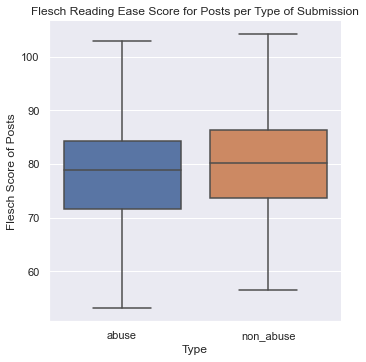

In [48]:
sns.set(rc={'figure.figsize':(6,4)})
ax1=sns.catplot(x='labels', y='flesch_score_posts', data=df, kind='box', showfliers = False)
ax1.set(xlabel='Type', ylabel='Flesch Score of Posts', title='Flesch Reading Ease Score for Posts per Type of Submission');

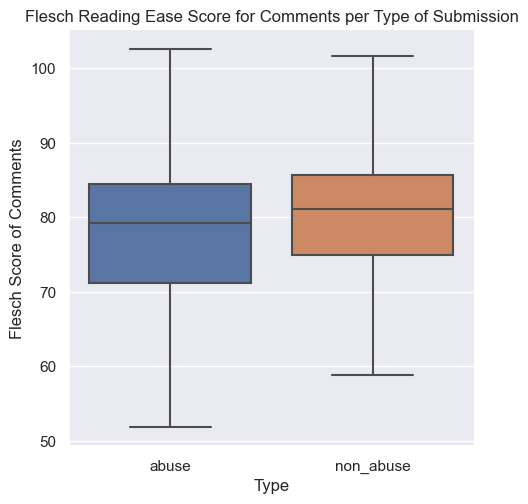

In [49]:
ax2=sns.catplot(x='labels', y='flesch_score_comments', data=df, kind='box', showfliers = False)
ax2.set(xlabel='Type', ylabel='Flesch Score of Comments', title='Flesch Reading Ease Score for Comments per Type of Submission');

In [50]:
df[df.flesch_score_posts<40][['posts', 'labels']]

,posts,labels
17,I'm doing a report on whether or not witnessin...,abuse
38,PTSD is NOT just for Veterans! I find it very ...,abuse
161,NS Court Gives Kids to Abusive Dad https://www...,abuse
201,Lets exchange pictures of fruit [Have you some...,non_abuse
261,Could my dad have a mental illness? My dad bel...,abuse
363,Differences between forums for estranged paren...,abuse
421,"Was your abuser a ""punisher?"" http://www.psych...",abuse
566,happy birthday to me indeed [tw: sexual assaul...,abuse
625,"""Apologies are meant to convey that the behavi...",abuse
661,Does Utah have a domestic violence epidemic? T...,abuse


In [51]:
df[df.flesch_score_comments<40][['posts', 'labels']]

,posts,labels
68,I can't tell if the nausea I'm having is anxie...,non_abuse
85,"Lolita is not a seductress. ""Lolita, in the bo...",abuse
146,Question for survivors from a baby lawyer. Hi ...,abuse
707,Anxiety books? Any suggestions on a good self ...,non_abuse
767,"""In the presence of primary aggression, couple...",abuse
919,"Triggered a year ago, then triggered again rec...",abuse
943,"Should we suspect sexual abuse, or is this par...",abuse
948,What is a good national organization I could r...,abuse
954,Birthdays are awesome. Domestic violence sucks...,abuse
1077,I just can't take it when people are wrong! I ...,non_abuse


In [52]:
df.posts[161]

'NS Court Gives Kids to Abusive Dad https://www.indiegogo.com/simple_campaigns/ns-court-gives-kids-to-abusive-dad/preview\n\nhttps://funds.gofundme.com/dashboard'

In [53]:
df.posts[661]

'Does Utah have a domestic violence epidemic? There are some alarming stats in this article. [www.ogden-attorney.com/domestic-violence-in-utah-is-growing-out-of-control/](http://www.ogden-attorney.com/domestic-violence-in-utah-is-growing-out-of-control/)'

In [54]:
df.comments[1077]

["I've recently read this book, if you are actually interested in fixing this problem, this would really help.",
 'http://www.amazon.com/Personality-Plus-Understand-Understanding-Yourself/dp/080075445X']

The readability of posts are mostly in the 70-79 range, categorized as a fairly easy reading difficulty. If we discount the urls, the reading scores would be higher.

In [55]:
from scipy.stats import ttest_ind
ttest_ind(df[df.labels=='abuse'].flesch_score_posts, df[df.labels=='non_abuse'].flesch_score_posts)

Ttest_indResult(statistic=-4.136929021119528, pvalue=3.787615631245558e-05)

In [56]:
ttest_ind(df[df.labels=='abuse'].flesch_score_comments, df[df.labels=='non_abuse'].flesch_score_comments)

Ttest_indResult(statistic=-3.557702712967931, pvalue=0.000390020188741754)

$H_0$: The difference in means of flesch scores between abuse and non-abuse posts/comments is 0.

$H_A$: The difference in eans of flesch scores between abuse and non-abuse posts/comments is not 0.

We can test for a similar one-tailed hypothesis to see if flesch score means in non-abuse posts/comments is higher by dividing the p-value by 2.

There is sufficient statistical evidence that means of flesch scores in non-abuse post/comments is higher.

## Capitalization

In [57]:
df[['post_caps', 'comments_caps']].describe()

,post_caps,comments_caps
count,1104.000000,1104.000000
mean,0.033263,0.029457
std,0.014679,0.020261
min,0.000000,0.000000
25%,0.025439,0.020445
50%,0.031120,0.025799
75%,0.038674,0.032640
max,0.159763,0.272727


In [58]:
df.groupby(by=['labels'])[['post_caps', 'comments_caps']].describe()

post_caps                                                         \
              count      mean       std  min       25%       50%       75%   
labels                                                                       
abuse         552.0  0.030893  0.012046  0.0  0.024638  0.029111  0.035635   
non_abuse     552.0  0.035633  0.016582  0.0  0.026891  0.032914  0.041363   

                    comments_caps                                     \
                max         count      mean       std  min       25%   
labels                                                                 
abuse      0.109677         552.0  0.027853  0.020657  0.0  0.019372   
non_abuse  0.159763         552.0  0.031061  0.019744  0.0  0.021549   

                                         
                50%       75%       max  
labels                                   
abuse      0.024238  0.030303  0.272727  
non_abuse  0.027669  0.035462  0.250000

In [59]:
df[df.post_caps>0.1][['posts', 'labels']]

,posts,labels
30,Cards Against Humanity! (Again Again!) Alright...,non_abuse
110,I REALLY just want someone to talk to. Things ...,non_abuse
266,I covered The Gardener by The Tallest Man On E...,non_abuse
476,THERE'S A HOLE IN MY SIDEWALK Autobiography in...,abuse
531,AHHHHHHHHH Just needed to scream so FUCKING TE...,non_abuse
778,"""My business will be shoving that phone up you...",non_abuse
816,Our furnace is broken and its 55 F in our hous...,non_abuse
1086,Poor me! Hugs for me!? I've had a bad day - an...,non_abuse


In [60]:
ttest_ind(df[df.labels=='abuse'].post_caps, df[df.labels=='non_abuse'].post_caps)

Ttest_indResult(statistic=-5.433332508260847, pvalue=6.805128926886908e-08)

In [61]:
ttest_ind(df[df.labels=='abuse'].comments_caps, df[df.labels=='non_abuse'].comments_caps)

Ttest_indResult(statistic=-2.6373270248545566, pvalue=0.008473838907834926)

$H_0$: The difference in means of % caps between abuse and non-abuse posts/comments is 0.

$H_A$: The difference in means of % caps between abuse and non-abuse posts/comments is not 0.

We can test for a similar one-tailed hypothesis to see if % caps means in non-abuse posts/comments is higher by dividing the p-value by 2.

There is sufficient statistical evidence that % of capitalization letters in non-abuse post/comments is higher than abuse posts/comments.

## Posts

In [62]:
df.post_char_count.describe()

count    1104.000000
mean     1082.455616
std       751.660994
min        13.000000
25%       473.750000
50%       889.000000
75%      1538.500000
max      4291.000000
Name: post_char_count, dtype: float64

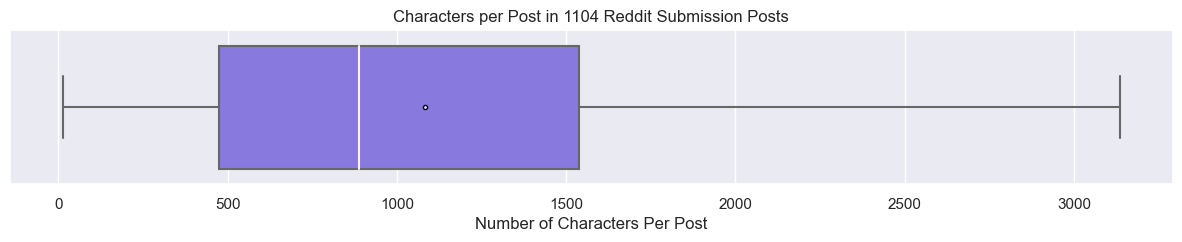

In [63]:
sns.set(rc={'figure.figsize':(15,2)})
b=sns.boxplot(x='post_char_count', data=df, showmeans=True, showfliers = False, color='mediumslateblue', medianprops={'color':'lavenderblush'}, meanprops={'marker':'.','markerfacecolor':'lavender','markeredgecolor':'black'})
b.set(xlabel='Number of Characters Per Post', title='Characters per Post in '+str(len(df.posts))+' Reddit Submission Posts');

In [64]:
df.post_word_count.describe()

count    1104.000000
mean      212.663043
std       148.805917
min         4.000000
25%        91.000000
50%       176.000000
75%       305.000000
max       816.000000
Name: post_word_count, dtype: float64

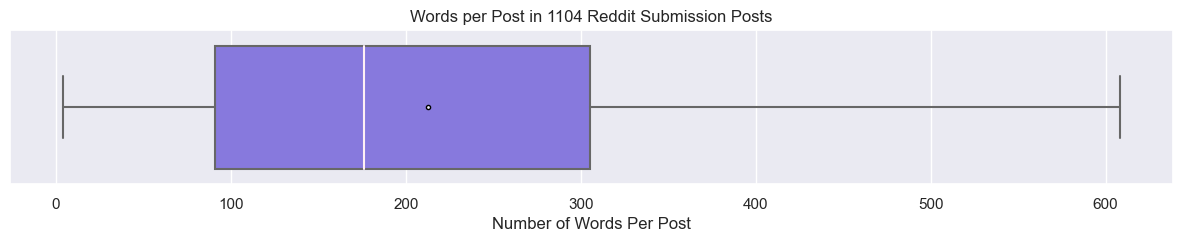

In [65]:
sns.set(rc={'figure.figsize':(15,2)})
b=sns.boxplot(x='post_word_count', data=df, showmeans=True, showfliers = False, color='mediumslateblue', medianprops={'color':'lavenderblush'}, meanprops={'marker':'.','markerfacecolor':'lavender','markeredgecolor':'black'})
b.set(xlabel='Number of Words Per Post', title='Words per Post in '+str(len(df.posts))+' Reddit Submission Posts');

In [66]:
df[df.post_word_count>680][['labels', 'posts']]

,labels,posts
581,abuse,I love her but I cannot forgive her. How do I ...
623,non_abuse,Anger at every turn I am angry. That is fact. ...
728,abuse,Recently out of a physically and emotionally a...
812,non_abuse,I think I lost who I was and now I'm a monster...


In [67]:
#preserve the average length of words per post
df['post_avg_word_length']=df.post_char_count/df.post_word_count
df.post_avg_word_length.describe()

count    1104.000000
mean        5.123363
std         0.349200
min         3.250000
25%         4.908129
50%         5.075378
75%         5.276905
max         7.631579
Name: post_avg_word_length, dtype: float64

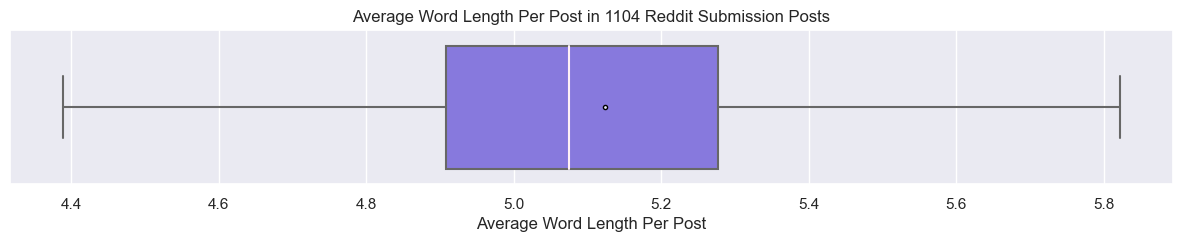

In [68]:
sns.set(rc={'figure.figsize':(15,2)})
b=sns.boxplot(x='post_avg_word_length', data=df, showmeans=True, showfliers = False, color='mediumslateblue', medianprops={'color':'lavenderblush'}, meanprops={'marker':'.','markerfacecolor':'lavender','markeredgecolor':'black'})
b.set(xlabel='Average Word Length Per Post', title='Average Word Length Per Post in '+str(len(df.posts))+' Reddit Submission Posts');

In [69]:
df[df.post_avg_word_length>7][['posts', 'labels']]

,posts,labels
363,Differences between forums for estranged paren...,abuse
767,"""In the presence of primary aggression, couple...",abuse


In [70]:
df.posts[767]

'"In the presence of primary aggression, couples\' therapy can become a tactic that actually makes the option of leaving the relationship less available to the survivor, which replicates the basic abusive maneuver." From [Abuse and Relationships: Couples Therapy](http://www.abuseandrelationships.org/Content/Survivors/couples_therapy.html)'

In [71]:
df.posts[363]

'Differences between forums for estranged parents and those for estranged children [Via Metafilter](http://www.metafilter.com/149244/The-abusers-side-of-the-story)\n\n---\n\n&gt; [Down the Rabbit Hole](http://www.issendai.com/psychology/estrangement/index.html) is a repository of observations about estranged parent support forums. It contains [comparisons of forum culture](http://www.issendai.com/psychology/estrangement/differences-between-forums.html) between discussion sites for estranged parents and those for children, [themes of discussion](http://www.issendai.com/psychology/estrangement/themes-our-children-want-to-hurt-us.html) found on estranged parent sites, and [possible reasons](http://www.issendai.com/psychology/estrangement/summary.html) estranged parent forums develop toxic dynamics.   \n\nInsightful and educational. Some topics might be triggering for some.'

The outliers with the highest average word length contain urls, which have been standardized in a way that accounts for the domain name plus the string 'url'.

In [72]:
df[df.post_avg_word_length<4].posts

949    hey what's up
Name: posts, dtype: object

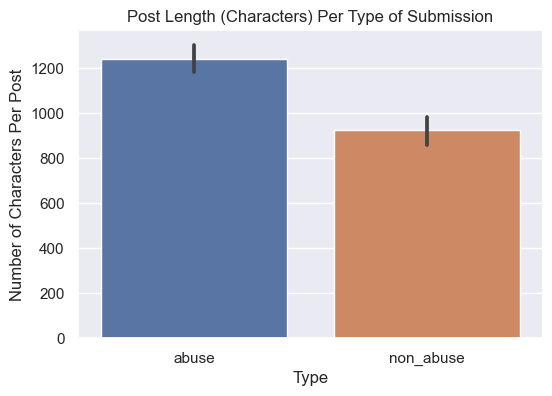

In [73]:
sns.set(rc={'figure.figsize':(6,4)})
bar=sns.barplot(x='labels', y='post_char_count', data=df)
bar.set(xlabel='Type', ylabel='Number of Characters Per Post', title='Post Length (Characters) Per Type of Submission');

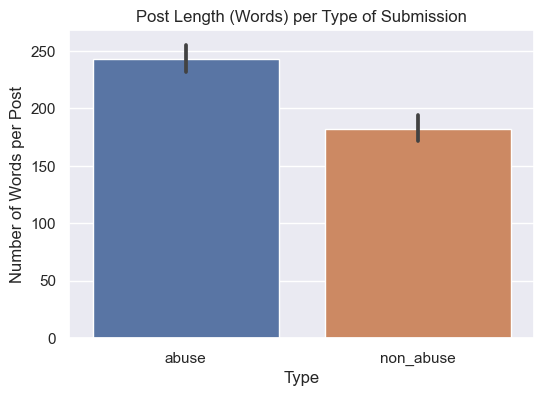

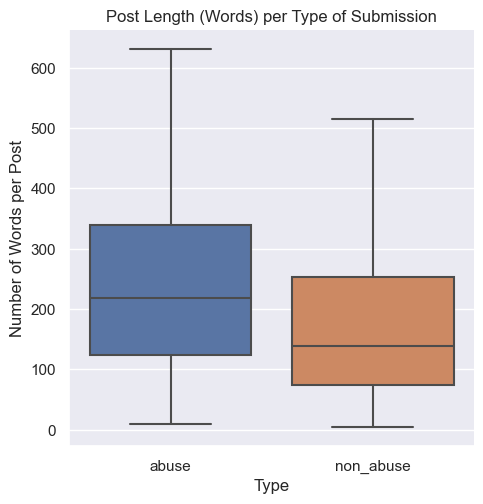

In [74]:
sns.set(rc={'figure.figsize':(6,4)})
ax1=sns.barplot(x='labels', y='post_word_count', data=df)
ax1.set(xlabel='Type', ylabel='Number of Words per Post', title='Post Length (Words) per Type of Submission')
ax2=sns.catplot(x='labels', y='post_word_count', data=df, kind='box', ax=ax2, showfliers = False)
ax2.set(xlabel='Type', ylabel='Number of Words per Post', title='Post Length (Words) per Type of Submission');

In [75]:
df.groupby(by=['labels']).post_avg_word_length.describe()

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
abuse,552.0,5.163949,0.369961,4.287879,4.926024,5.095984,5.291648,7.631579
non_abuse,552.0,5.082776,0.322382,3.250000,4.894839,5.050956,5.249567,6.878788


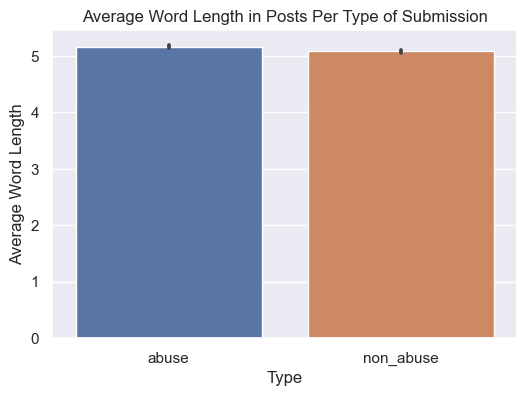

In [76]:
sns.set(rc={'figure.figsize':(6,4)})
bar=sns.barplot(x='labels', y='post_avg_word_length', data=df)
bar.set(xlabel='Type', ylabel='Average Word Length', title='Average Word Length in Posts Per Type of Submission');

In [77]:
ttest_ind(df[df.labels=='abuse'].post_avg_word_length, df[df.labels=='non_abuse'].post_avg_word_length)

Ttest_indResult(statistic=3.886420866027959, pvalue=0.00010780242482072949)

In [78]:
ttest_ind(df[df.labels=='abuse'].post_word_count, df[df.labels=='non_abuse'].post_word_count)

Ttest_indResult(statistic=6.933847503397608, pvalue=6.963332045837476e-12)

Posts related to abuse are longer, containing more characters and words. The outliers that have the most word counts were equally labeled abuse or non-abuse.

## Comments

In [79]:
#divide by the number of comments to get the average number of characters in each comment
df.comments_char_count=df.comments_char_count/df.comments_count
df.comments_char_count.describe()

count    1104.000000
mean      256.657492
std       180.975541
min         5.000000
25%       144.971154
50%       221.704545
75%       323.575000
max      2302.000000
Name: comments_char_count, dtype: float64

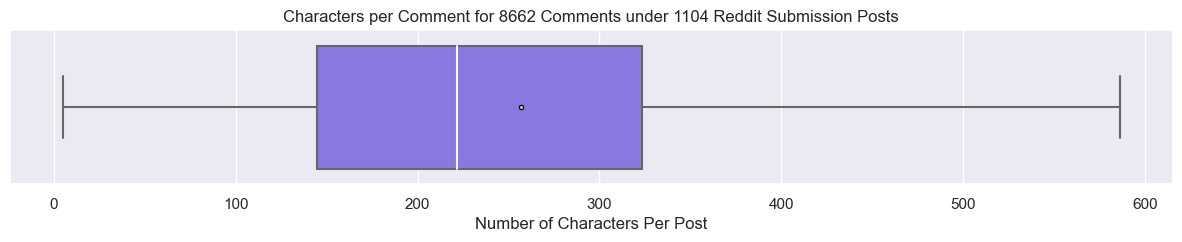

In [80]:
sns.set(rc={'figure.figsize':(15,2)})
b=sns.boxplot(x='comments_char_count', data=df, showfliers = False, showmeans=True, color='mediumslateblue', medianprops={'color':'lavenderblush'}, meanprops={'marker':'.','markerfacecolor':'lavender','markeredgecolor':'black'})
b.set(xlabel='Number of Characters Per Post', title='Characters per Comment for '+ str(sum(df.comments_count))+ ' Comments under '+str(len(df.posts))+' Reddit Submission Posts');

In [81]:
#get average number of words in each comment
df.comments_word_count=df.comments_word_count/df.comments_count
df.comments_word_count.describe()

count    1104.000000
mean       49.488810
std        34.603015
min         1.000000
25%        28.000000
50%        42.208333
75%        62.852273
max       444.000000
Name: comments_word_count, dtype: float64

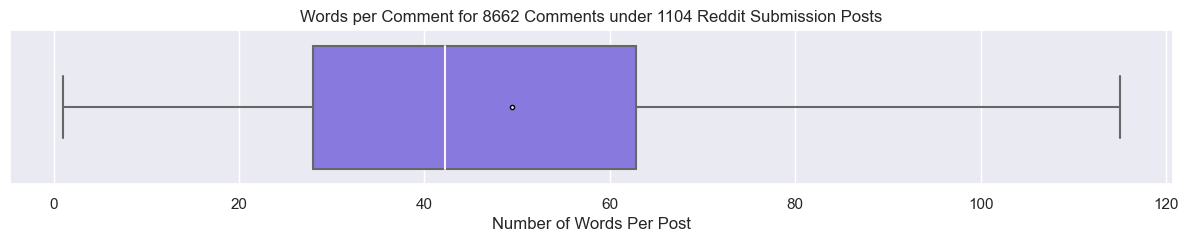

In [82]:
sns.set(rc={'figure.figsize':(15,2)})
b=sns.boxplot(x='comments_word_count', data=df, showmeans=True, showfliers = False, color='mediumslateblue', medianprops={'color':'lavenderblush'}, meanprops={'marker':'.','markerfacecolor':'lavender','markeredgecolor':'black'})
b.set(xlabel='Number of Words Per Post', title='Words per Comment for '+ str(sum(df.comments_count))+ ' Comments under '+str(len(df.posts))+' Reddit Submission Posts');

In [83]:
df[df.comments_word_count>800][['posts', 'comments', 'labels', 'comments_count']]

,posts,comments,labels,comments_count


In [84]:
df.comments_count.describe()

count    1104.000000
mean        7.846014
std        11.898019
min         1.000000
25%         2.000000
50%         5.000000
75%         9.000000
max       207.000000
Name: comments_count, dtype: float64

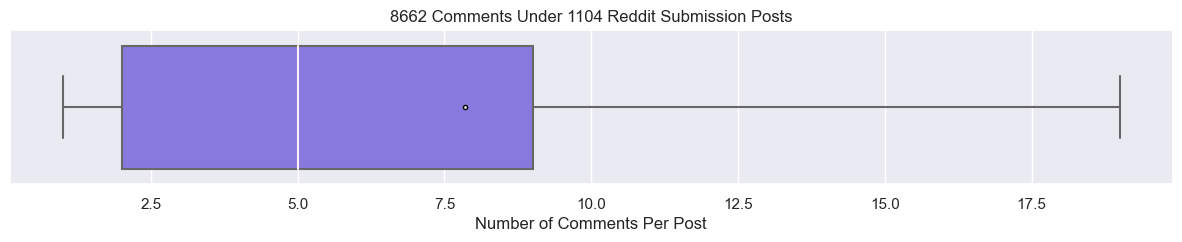

In [85]:
sns.set(rc={'figure.figsize':(15,2)})
b=sns.boxplot(x='comments_count', data=df, showmeans=True, showfliers = False, color='mediumslateblue', medianprops={'color':'lavenderblush'}, meanprops={'marker':'.','markerfacecolor':'lavender','markeredgecolor':'black'})
b.set(xlabel='Number of Comments Per Post', title=str(sum(df.comments_count))+' Comments Under ' + str(len(df.comments_count))+' Reddit Submission Posts');

In [86]:
df[df.comments_count>40][['posts', 'comments', 'labels']]

,posts,comments,labels
40,Foodie Friday. Make me hungry Post a **photo**...,[No prob! [Here's a bonus pic of my desert](ht...,non_abuse
59,What kind of phone do you guys use? Like the t...,[Does the big screen and battery life make it ...,non_abuse
88,What do you love and hate about your name? I h...,[YES!! on the latter. I wish I was named Beeth...,non_abuse
125,What do you like to do in your free time? I li...,[I'm on NA and LAN! My summoner is Khanthulhu....,non_abuse
166,I've been sick for five days and am alone in t...,"[Aren't we already?, Portlandia, I'm still you...",non_abuse
180,In this thread: songs that invoke massive feel...,[[Gowan: A Criminal Mind creeped me the fuck o...,non_abuse
278,I am so afraid to speak at my dad's funeral to...,[I totally agree on your point. The decision a...,non_abuse
300,I'm about to become a liability to people who ...,"[This seems like a very complicated, serious m...",non_abuse
315,You guys ever have a song lyric just hit you l...,"[""you're on your 5th drink with no bars in sig...",non_abuse
341,So glad to find this sub. My wife left me beca...,"[Your self-honesty is amazing, and is incredib...",abuse


In [87]:
df.posts[125]

'What do you like to do in your free time? I like to practice soccer and cuddle with my kids in my free time!\n\nWhat do you like to do?'

In [88]:
df.posts[88]

'What do you love and hate about your name? I hate the fact that i\'ve never heard it in the way it was intended to sound, because we moved to a different country when i was a kid. As if my name was "John", but everyone just calls me "Juan".\n\nI like the short versions of my name, and its versatility.'

In [89]:
df.posts[1003]

"How is everyone's President's Day going? I woke up early, all tired and groggy and realized half way through my shower that I did not have school today, so I have an unexpected day off! (Well one I forgot about) :)\n\nHow is everyone else doing this fine day?"

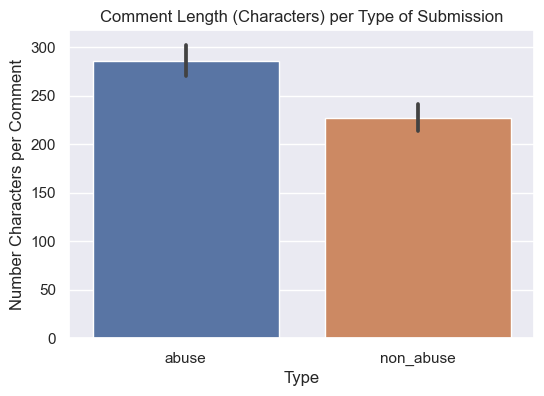

In [90]:
sns.set(rc={'figure.figsize':(6,4)})
bar=sns.barplot(x='labels', y='comments_char_count', data=df)
bar.set(xlabel='Type', ylabel='Number Characters per Comment', title='Comment Length (Characters) per Type of Submission');

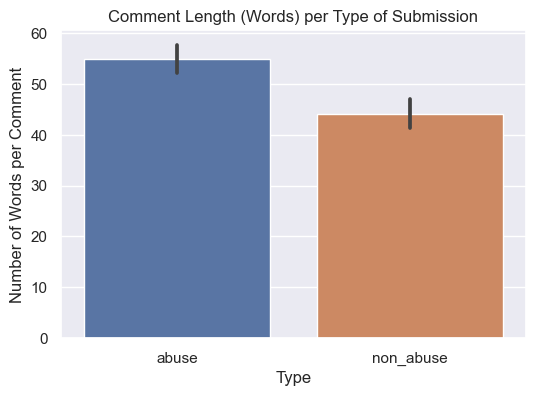

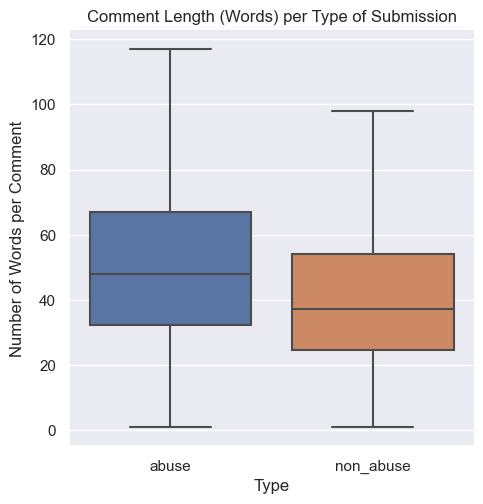

In [91]:
ax1=sns.barplot(x='labels', y='comments_word_count', data=df)
ax1.set(xlabel='Type', ylabel='Number of Words per Comment', title='Comment Length (Words) per Type of Submission')
ax2=sns.catplot(x='labels', y='comments_word_count', data=df, showfliers=False, kind='box', ax=ax2)
ax2.set(xlabel='Type', ylabel='Number of Words per Comment', title='Comment Length (Words) per Type of Submission');

In [92]:
df.groupby(by='labels').comments_word_count.describe()

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
abuse,552.0,54.804069,35.467863,1.0,32.237500,47.875,67.000000,270.0
non_abuse,552.0,44.173551,32.898853,1.0,24.668103,37.125,54.039474,444.0


In [93]:
df['comments_avg_word_length']=df.comments_char_count/df.comments_word_count
df.comments_avg_word_length.describe()

count    1104.000000
mean        5.195478
std         0.328391
min         3.666667
25%         5.011211
50%         5.175940
75%         5.336184
max         9.000000
Name: comments_avg_word_length, dtype: float64

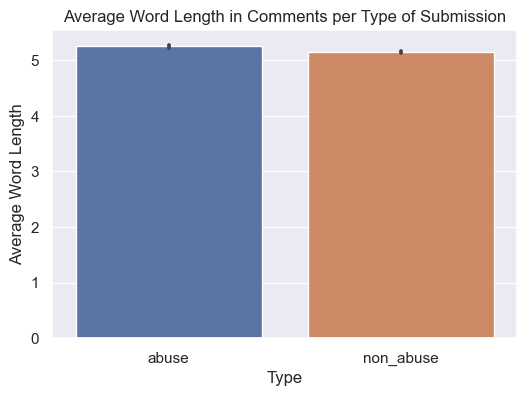

In [94]:
bar=sns.barplot(x='labels', y='comments_avg_word_length', data=df)
bar.set(xlabel='Type', ylabel='Average Word Length', title='Average Word Length in Comments per Type of Submission');

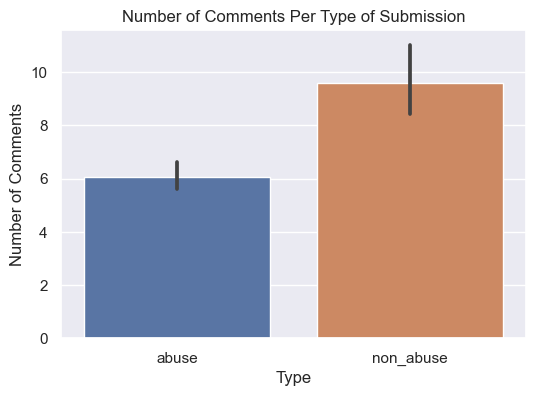

In [95]:
bar=sns.barplot(x='labels', y='comments_count', data=df)
bar.set(xlabel='Type', ylabel='Number of Comments', title='Number of Comments Per Type of Submission');

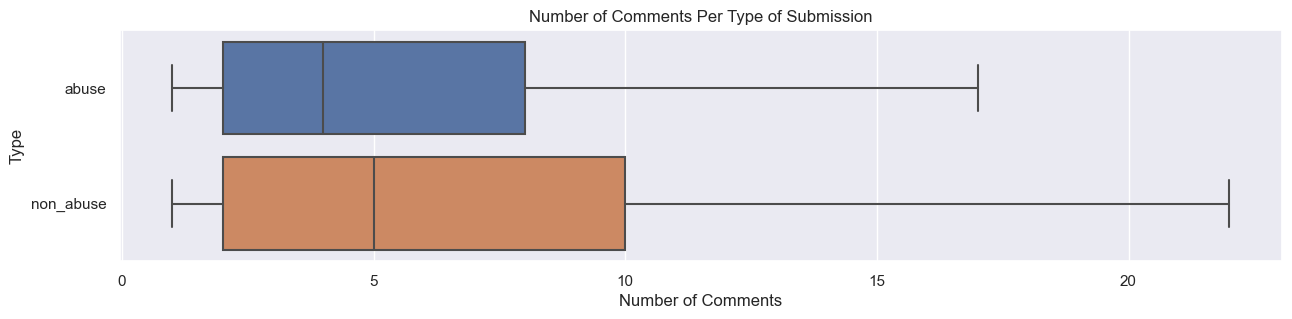

In [96]:
sns.set(rc={'figure.figsize':(15,3)})
box=sns.boxplot(y='labels', x='comments_count', data=df, showfliers = False)
box.set(ylabel='Type', xlabel='Number of Comments', title='Number of Comments Per Type of Submission');

In [97]:
df.groupby(by='labels').comments_count.describe()

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
abuse,552.0,6.077899,6.250902,1.0,2.0,4.0,8.0,67.0
non_abuse,552.0,9.614130,15.428708,1.0,2.0,5.0,10.0,207.0


In [98]:
ttest_ind(df[df.labels=='abuse'].comments_avg_word_length, df[df.labels=='non_abuse'].comments_avg_word_length)

Ttest_indResult(statistic=5.093993102901979, pvalue=4.121989723771118e-07)

All posts in this dataset have at least 1 comment, and over 50% of the posts have under 5 comments. The most popular post has 207 comments. These outliers are labeled non-abuse and contain questions directed towards other Redditors about themselves while sharing their own experiences. 

Posts about abuse tend to be longer, while having less comments. However, the comments under posts about abuse tend to be longer.

## Sentiment Analysis

In [99]:
from collections import Counter

In [100]:
post_columns={'anger_post':'Anger', 'disgust_post':'Disgust', 'fear_post':'fear', 'happy_post':'Happy', 'neutral_post':'Neutral', 'sad_post':'Sad', 'surprise_post': 'Surprise'}

In [101]:
comments_columns={'anger_comments':'Anger', 'disgust_comments':'Disgust', 'fear_comments':'Fear', 'happy_comments':'Happy', 'neutral_comments':'Neutral', 'sad_comments': 'Sad', 'surprise_comments': 'Surprise'}

In [102]:
post_sentiments=pd.DataFrame(df[post_columns.keys()].sum(), columns=['Score']).reset_index(drop=True)
post_sentiments['Sentiment']=post_columns.values()
post_sentiments=post_sentiments[['Sentiment', 'Score']]
post_sentiments

,Sentiment,Score
0,Anger,29.966094
1,Disgust,6.311606
2,fear,27.044529
3,Happy,28.111098
4,Neutral,2.576587
5,Sad,23.569424
6,Surprise,23.751221


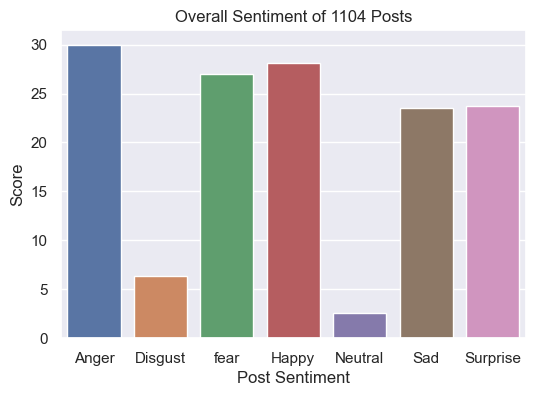

In [103]:
sns.set(rc={'figure.figsize':(6,4)})
b=sns.barplot(x='Sentiment', y='Score', data=post_sentiments)
b.set(xlabel='Post Sentiment', title='Overall Sentiment of '+str(len(df.post_sentiment))+' Posts');

In [104]:
comments_sentiments=pd.DataFrame(df[comments_columns.keys()].sum(), columns=['Score']).reset_index(drop=True)
comments_sentiments['Sentiment']=comments_columns.values()
comments_sentiments=comments_sentiments[['Sentiment', 'Score']]
comments_sentiments

,Sentiment,Score
0,Anger,27.337408
1,Disgust,5.510563
2,Fear,26.340923
3,Happy,30.184215
4,Neutral,3.155891
5,Sad,22.451903
6,Surprise,23.622872


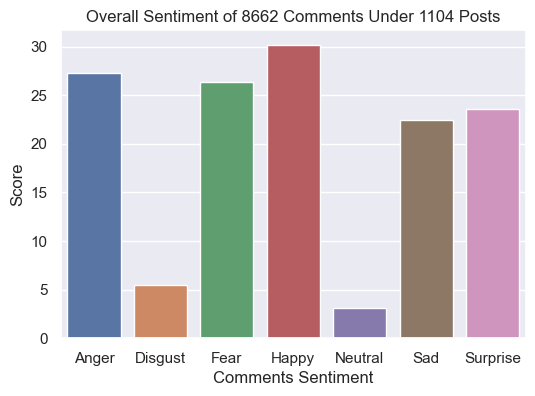

In [105]:
sns.set(rc={'figure.figsize':(6,4)})
b=sns.barplot(x='Sentiment', y='Score', data=comments_sentiments)
b.set(xlabel='Comments Sentiment', title='Overall Sentiment of '+str(sum(df.comments_count))+' Comments Under '+str(len(df.post_sentiment))+' Posts');

The comment section has more happy words and less angry words, but the posts and comments seem to contain more or less the same sentiments.

In [106]:
post_sentiments=pd.DataFrame(df.groupby('labels')[list(post_columns.keys())].sum().transpose()).reset_index()
post_sentiments=post_sentiments.rename(columns={'index':'Sentiment'})
post_sentiments['Sentiment']=post_columns.values()
post_sentiments=pd.melt(post_sentiments, id_vars='Sentiment')
post_sentiments

,Sentiment,labels,value
0,Anger,abuse,17.217184
1,Disgust,abuse,3.569733
2,fear,abuse,13.083963
3,Happy,abuse,13.819529
4,Neutral,abuse,1.244763
5,Sad,abuse,11.217937
6,Surprise,abuse,11.647137
7,Anger,non_abuse,12.748910
8,Disgust,non_abuse,2.741874
9,fear,non_abuse,13.960566


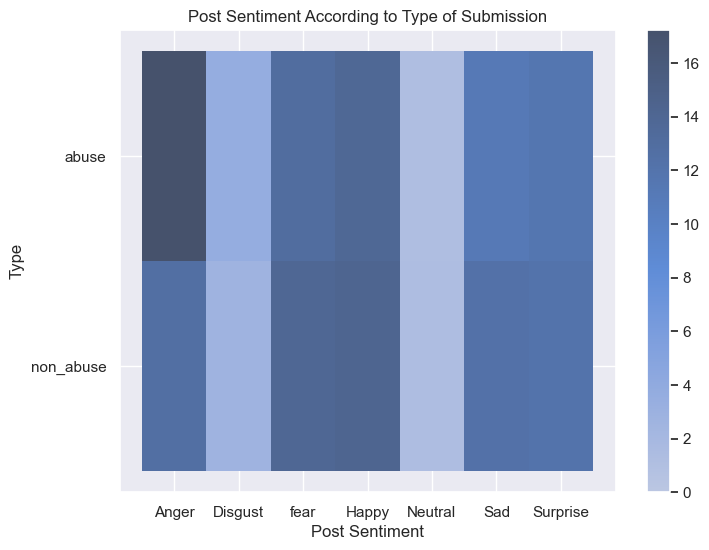

In [107]:
sns.set(rc={'figure.figsize':(8,6)})
h=sns.histplot(x='Sentiment', y='labels', data=post_sentiments, weights='value', cbar=True)
h.set(xlabel='Post Sentiment', ylabel='Type', title='Post Sentiment According to Type of Submission');

In [108]:
post_columns

{'anger_post': 'Anger',
 'disgust_post': 'Disgust',
 'fear_post': 'fear',
 'happy_post': 'Happy',
 'neutral_post': 'Neutral',
 'sad_post': 'Sad',
 'surprise_post': 'Surprise'}

In [109]:
post_sentiments=pd.DataFrame(df.groupby('labels')[list(post_columns.keys())].sum())
post_sentiments.rename(columns=post_columns, inplace=True)
post_sentiments=post_sentiments.div(post_sentiments.sum(axis=1), axis=0) #percent stacked
post_sentiments.head()

,Anger,Disgust,fear,Happy,Neutral,Sad,Surprise
labels,,,,,,,
abuse,0.239793,0.049718,0.182227,0.192472,0.017336,0.156238,0.162216
non_abuse,0.183358,0.039434,0.200784,0.205544,0.019155,0.177642,0.174084


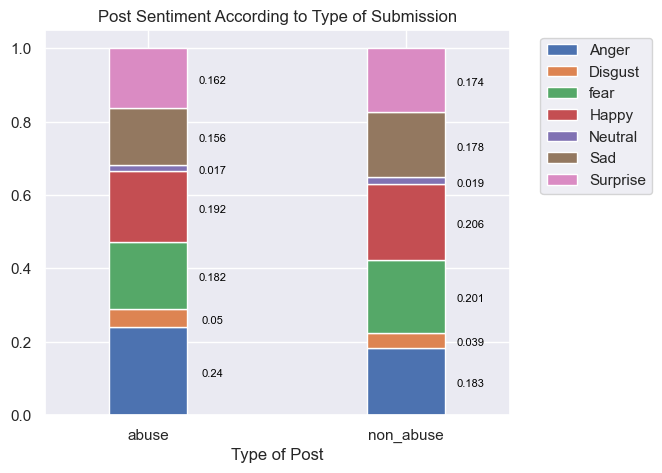

In [110]:
sns.set(rc={'figure.figsize':(6,5)})
ax=post_sentiments.plot(kind='bar', stacked=True, legend='reverse', width=0.3)
ax.set(xlabel='Type of Post', title='Post Sentiment According to Type of Submission')
plt.legend(bbox_to_anchor=(1.05,1))
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{np.round(height,3)}', (x + 0.4, y + height/2 -0.015), ha='center', fontsize=8, color='black')


plt.xticks(rotation=0);

In [111]:
post_columns.values()

dict_values(['Anger', 'Disgust', 'fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

In [112]:
post_columns.keys()

dict_keys(['anger_post', 'disgust_post', 'fear_post', 'happy_post', 'neutral_post', 'sad_post', 'surprise_post'])

In [113]:
post_sentiments

,Anger,Disgust,fear,Happy,Neutral,Sad,Surprise
labels,,,,,,,
abuse,0.239793,0.049718,0.182227,0.192472,0.017336,0.156238,0.162216
non_abuse,0.183358,0.039434,0.200784,0.205544,0.019155,0.177642,0.174084


In [114]:
comments_sentiments=pd.DataFrame(df.groupby('labels')[list(comments_columns.keys())].sum().transpose()).reset_index()
comments_sentiments=comments_sentiments.rename(columns={'index':'Sentiment'})
comments_sentiments['Sentiment']=comments_columns.values()
comments_sentiments=pd.melt(comments_sentiments, id_vars='Sentiment')
comments_sentiments

,Sentiment,labels,value
0,Anger,abuse,15.038037
1,Disgust,abuse,2.867249
2,Fear,abuse,12.983638
3,Happy,abuse,15.124527
4,Neutral,abuse,1.540718
5,Sad,abuse,10.667063
6,Surprise,abuse,11.360517
7,Anger,non_abuse,12.299372
8,Disgust,non_abuse,2.643314
9,Fear,non_abuse,13.357285


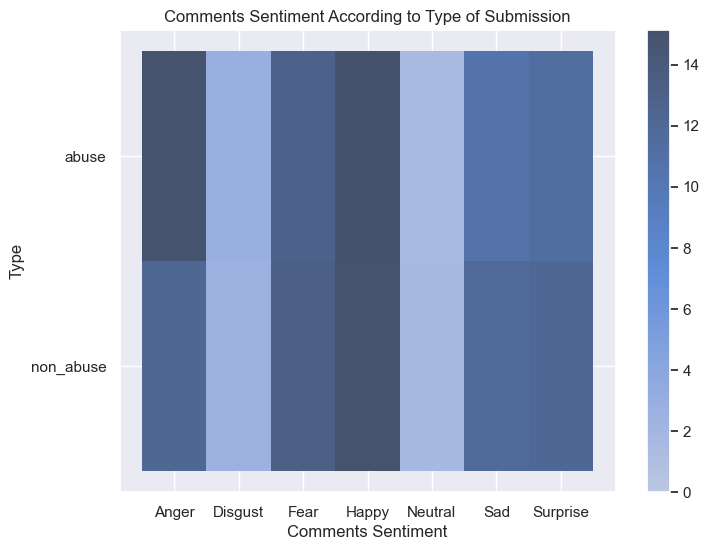

In [115]:
sns.set(rc={'figure.figsize':(8,6)})
h=sns.histplot(x='Sentiment', y='labels', data=comments_sentiments, weights='value', cbar=True)
h.set(xlabel='Comments Sentiment', ylabel='Type', title='Comments Sentiment According to Type of Submission');

In [116]:
comments_sentiments=pd.DataFrame(df.groupby('labels')[list(comments_columns.keys())].sum())
comments_sentiments.rename(columns=comments_columns, inplace=True)
comments_sentiments=comments_sentiments.div(comments_sentiments.sum(axis=1), axis=0) #percent stacked
comments_sentiments.head()

,Anger,Disgust,Fear,Happy,Neutral,Sad,Surprise
labels,,,,,,,
abuse,0.216120,0.041207,0.186595,0.217363,0.022143,0.153303,0.163269
non_abuse,0.178195,0.038297,0.193522,0.218187,0.023401,0.170740,0.177659


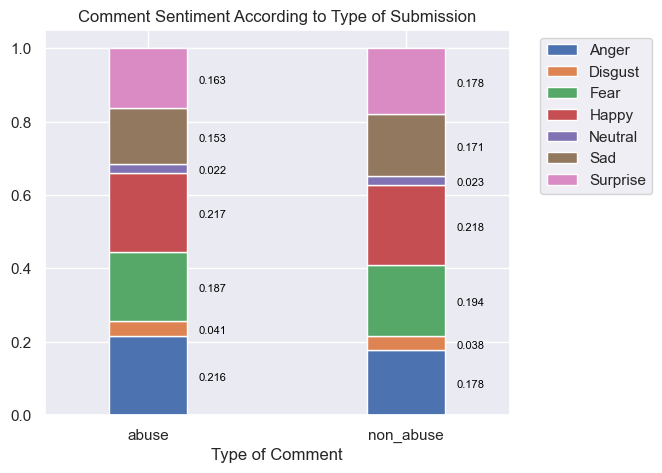

In [117]:
sns.set(rc={'figure.figsize':(6,5)})
ax=comments_sentiments.plot(kind='bar', stacked=True, legend='reverse', width=0.3)
ax.set(xlabel='Type of Comment', title='Comment Sentiment According to Type of Submission')
plt.legend(bbox_to_anchor=(1.05,1))

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{np.round(height,3)}', (x + 0.4, y + height/2 -0.015), ha='center', fontsize=8, color='black')

plt.xticks(rotation=0);

In [118]:
#The post_sentiment and comments_sentiment columns denote the emotion with the maximum score per post/comment,
#and post_sentiment_words and comments_sentiment_words denote the words corresponding to this emotion sorted
#by descending scores. 

#The first word of each row denotes the token with highest score of this sentiment.

df[(df.comments_sentiment=='happy') & (df.labels=='abuse')]['comments_sentiment_words']

13      [protect, love, grow, heard, daughter, daughte...
14                                  [peace, need, seeing]
16      [special, special, love, love, better, better,...
23           [sense, good, good, trust, sexual, identity]
29      [soul, acceptance, happy, happy, happy, happy,...
                              ...                        
1079    [protect, toward, important, truth, care, face...
1082    [hidden, great, spot, spot, well, cost, hit, s...
1088                               [happy, good, sharing]
1095    [positive, love, love, love, love, love, love,...
1098    [beautiful, healthy, perfect, love, love, love...
Name: comments_sentiment_words, Length: 206, dtype: object

In [119]:
df.comments[29][8]

"It's always there but it does get better. As time goes on it becomes less and less a part of you."

In [120]:
df.comments[1095][0]

"I haven't specifically had a family like this, though I'm realizing more and more how they often weren't there for me or helped when I really asked for help and start to become very unhappy as a kid, and they were always emotionally quite closed off, but I've had the kind of feelings you describe a lot with my total lack of friends/relationships. Everyone seems to have them and find it easy to make them etc, and yes it is really hard living without that support that everyone seems to take for granted. I've felt extremely alone for years because of this. I'm really glad that you have someone who really cares for you now though. I agree with what yummy_babies said, you can be your own support in a way by loving yourself and and staying positive and supportive for your own wellbeing, as you deserve that love and support even if its from yourself. Maybe that doesn't help very much but I think its easy to forget to love and support yourself sometimes."

In [121]:
df[(df.comments_sentiment=='anger') & (df.labels=='non_abuse')]['comments_sentiment_words']

3                                     [wrong, yeah, yeah]
34      [forced, guarantee, either, degree, career, ne...
63      [wrong, heavy, intended, bag, bag, needed, bet...
72      [negative, wrong, wrong, fight, script, attent...
87      [fail, saying, either, carry, degree, slow, go...
                              ...                        
1011    [mg, mg, mg, mg, mg, mg, mg, palm, wish, clear...
1018    [wrong, shared, taken, prepared, fact, felt, n...
1075                           [bad, gone, normal, great]
1089    [wrong, brother, became, fix, sorry, break, ex...
1103    [negative, protected, sorry, damage, fact, gav...
Name: comments_sentiment_words, Length: 79, dtype: object

In [122]:
df.comments[34]

["Yeah that's what I'm starting to believe... thank you so much!",
 "I'm a diligent person so I know I'd go back. I have to anyway because I need the higher degree for my career. ",
 "I'm just more the type who hates uncertainty. Because if I took the year off there's no guarantee in getting accepted. Or what if something else happens in between? A lot of worry on my part.",
 "Still apply to schools but if you don't get accepted you may have no choice.",
 "That's what I'm thinking. I may not get into this other program either and then I'm forced to take a year off.",
 "I wouldn't have to but I would be doing it. I'd be gaining experience in the field which would help in my application.",
 'would you have to do something that looks good on applications in that year?',
 "It depends on your personality. If you are diligent and you have no doubt that you could take a year off and get right back to it then get the work experience. But if you think you will dread going back and hate that you

In [123]:
df[(df.comments_sentiment=='fear') & (df.labels=='non_abuse')]['comments_sentiment_words']

1       [hope, posting, doctor, doctor, doctor, doctor...
5                                       [highly, suggest]
28                             [attack, thanks, bad, fun]
31      [lost, moment, walk, wall, hole, kept, slow, g...
66      [attack, attack, die, exposure, exposure, litt...
                              ...                        
1061    [fear, fear, doctor, doctor, benefit, benefit,...
1062                                             [happen]
1063    [attack, prescription, doc, doc, straight, tal...
1083    [attack, attack, fear, fear, greater, hope, ho...
1090    [flight, flight, doctor, bed, need, clear, cle...
Name: comments_sentiment_words, Length: 116, dtype: object

In [124]:
df.comments[1061]

["Sounds like you are ready to give up struggling against anxiety. That's great! It's the struggling that is the problem, not anxiety. The fear of fear is the problem and it's just a habit we learned. The good news is you can unlearn it, but it takes some of your time and discipline.",
 "The best advice I can offer is to learn to meditate. It's the only thing I have really stuck at. Ever. and I can be the laziest, most anxious person I know.",
 'It is simple but difficult. I started with an 8 week mindfulness course with the Pain Service from my local doctors. This was enough to get me over the initial confusion and created a habit of daily meditation. The benefits are seemingly lifelong and have been well researched to be effective.',
 'Once I started to feel the benefits from meditation I started doing some *mindful* yoga, which is just moving meditation. From there it started to seep into my everyday life. I started noticing good things that were going on in my life, things that wer

Posts labeled as abuse mostly express angry emotions, and comments under these posts express both anger and happiness. It can be seen that the most 'happy' words are also 'positive' words of comfort and advice such as *love, happy,* and *protect*, but they can also be used to skepticism against being able to be happy. The 'happy' emotion is the most prominent in the non-abuse posts & dominates the non-abuse comment section.

While posts labeled as non-abuse seem to have less emotions of anger, it is still quite prominent (third most common emotion) with tokens like *mg, wrong*, and *negative*. Fear was actually more common in non-abuse posts and comments, with prominent fear words being *doctor, attack,* and *hope* 

Emotions of disgust and neutrality were the least common in this dataset.


In [125]:
df.to_csv('Final_reddit.csv')